# Node Classifier Notebook

This notebook gives an overview of the process of creating and training a classifier model. It serves as a playground for quick iteration. For larger parameter sweeps, using the Weights&Biases sweeper procedure outlined in the `classifier_sweeper` file is recommended.

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import pickle
from tqdm import tqdm
from pathlib import Path

%load_ext autoreload
%autoreload 2
from base import datahandler, prediction_models, evaluation, classifier, utils

utils.set_random_seed(42)

2024-04-14 22:28:53.138736: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-14 22:28:53.138797: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-14 22:28:53.139819: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-14 22:28:53.147280: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-14 22:28:54.132007: W tensorflow/compiler/tf2

#### Dataset Preparation

In [2]:
# Define the directory paths
challenge_data_dir = Path('dataset/phase_2')
train_val_data_dir = challenge_data_dir / "training"
train_val_labels_dir = challenge_data_dir / 'train_label.csv'

test_data_dir = challenge_data_dir / "test"
test_labels_dir = challenge_data_dir / 'test_label.csv'

train_val_df_dict = datahandler.load_and_prepare_dataframes(train_val_data_dir, train_val_labels_dir, dtype=np.float32)
test_df_dict = datahandler.load_and_prepare_dataframes(test_data_dir, test_labels_dir, dtype=np.float32)

In [19]:
# Create the dataset generator - this is where most of the preprocessing happens
# A more detailed documentation of the different paramters can be found in the DatasetGenerator implementation
ds_gen = datahandler.DatasetGenerator(
                                    # Input Data
                                    train_val_df_dict=train_val_df_dict,
                                    test_df_dict=test_df_dict,
                                    exclude_objects=[9, 10, 13, 19, 30, 113, 1012, 1383, 1385, 1386, 1471, 1473, 1474],
                                    
                                    # General dataset settings
                                    padding='zero',
                                    shuffle_train_val=True,
                                    train_val_split=0.8,
                                    unify_value_ranges=True,

                                    # Input horizons & stride
                                    input_history_steps=32,
                                    input_future_steps=256,
                                    input_stride=1,

                                    # Input features
                                    non_transform_features=['Eccentricity',
                                                            'Semimajor Axis (m)',
                                                            #'Inclination (deg)',
                                                            'RAAN (deg)',
                                                            #'Argument of Periapsis (deg)',
                                                            'True Anomaly (deg)',
                                                            'Latitude (deg)',
                                                            #'Longitude (deg)',
                                                        ],
                                    diff_transform_features=['Eccentricity',
                                                            'Semimajor Axis (m)',
                                                            'Inclination (deg)',
                                                            #'RAAN (deg)',
                                                            #'Argument of Periapsis (deg)',
                                                            'True Anomaly (deg)',
                                                            #'Longitude (deg)',
                                                            #'Latitude (deg)'
                                                        ],
                                    sin_transform_features=[ #'Inclination (deg)',
                                                            #'RAAN (deg)',
                                                            'Argument of Periapsis (deg)',
                                                            #'True Anomaly (deg)',
                                                            'Longitude (deg)',
                                                            #'Latitude (deg)'
                                                        ],
                                    sin_cos_transform_features=[],
                                    overview_features_mean=[],
                                    overview_features_std=[
                                                        'Argument of Periapsis (sin)',
                                                        'Latitude (deg)',
                                                        'Longitude (sin)'
                                                        ],
                                    lowpass_features=[#'Eccentricity',
                                                        #'Semimajor Axis (m)',
                                                        #'Inclination (deg)',
                                                        #'RAAN (deg)',
                                                        #'Argument of Periapsis (deg)',
                                                        #'True Anomaly (deg)',
                                                        #'Latitude (deg)',
                                                        #'Longitude (deg)',
                                                        ],
                                    add_daytime_feature=False,
                                    add_yeartime_feature=False,
                                    add_linear_timeindex=True,

                                    # Input transformation details
                                    legacy_diff_transform=False,
                                    linear_timeindex_as_overview=True, # this is changed to be identical to the setting of the localizers
                                    scale=True,
                                    custom_scaler=None,
                                    per_object_scaling=False,
                                    
                                    # Labels
                                    nodes_to_include_as_locations=['SS', 'AD', 'IK', 'ID'],
                                    
                                    # Miscellaneous
                                    input_dtype=np.float32,
                                    sort_input_features=True,
                                    seed=11,
                                    deepcopy=True)


=========================Creating Generator=======================
Seed: 11
nTrain: 1511 nVal: 376 nTest: 499 (train-val-split: 0.80)
Padding: zero
Horizons: 32-256 @ stride 1
Scaling: True  
Limiting True Anomaly to [0.0, 360.0] and Longitude to [-180.0, 180.0]
Sin-Transforming features: ['Argument of Periapsis (deg)', 'Longitude (deg)']
Sin-Cos-Transforming features: []
Diff Transforming features: ['Eccentricity', 'Semimajor Axis (m)', 'Inclination (deg)', 'True Anomaly (deg)']
Adding linear timeindex.
Final 15 input features: ['Argument of Periapsis (sin)', 'Eccentricity', 'Eccentricity (diff)', 'Inclination (deg) (diff)', 'Latitude (deg)', 'LinearTimeIndex', 'Longitude (sin)', 'RAAN (deg)', 'Semimajor Axis (m)', 'Semimajor Axis (m) (diff)', 'True Anomaly (deg)', 'True Anomaly (deg) (diff)'] + overview of [] (mean) and ['Argument of Periapsis (sin)', 'Latitude (deg)', 'Longitude (sin)'] (std)
=========================Finished Generator=======================


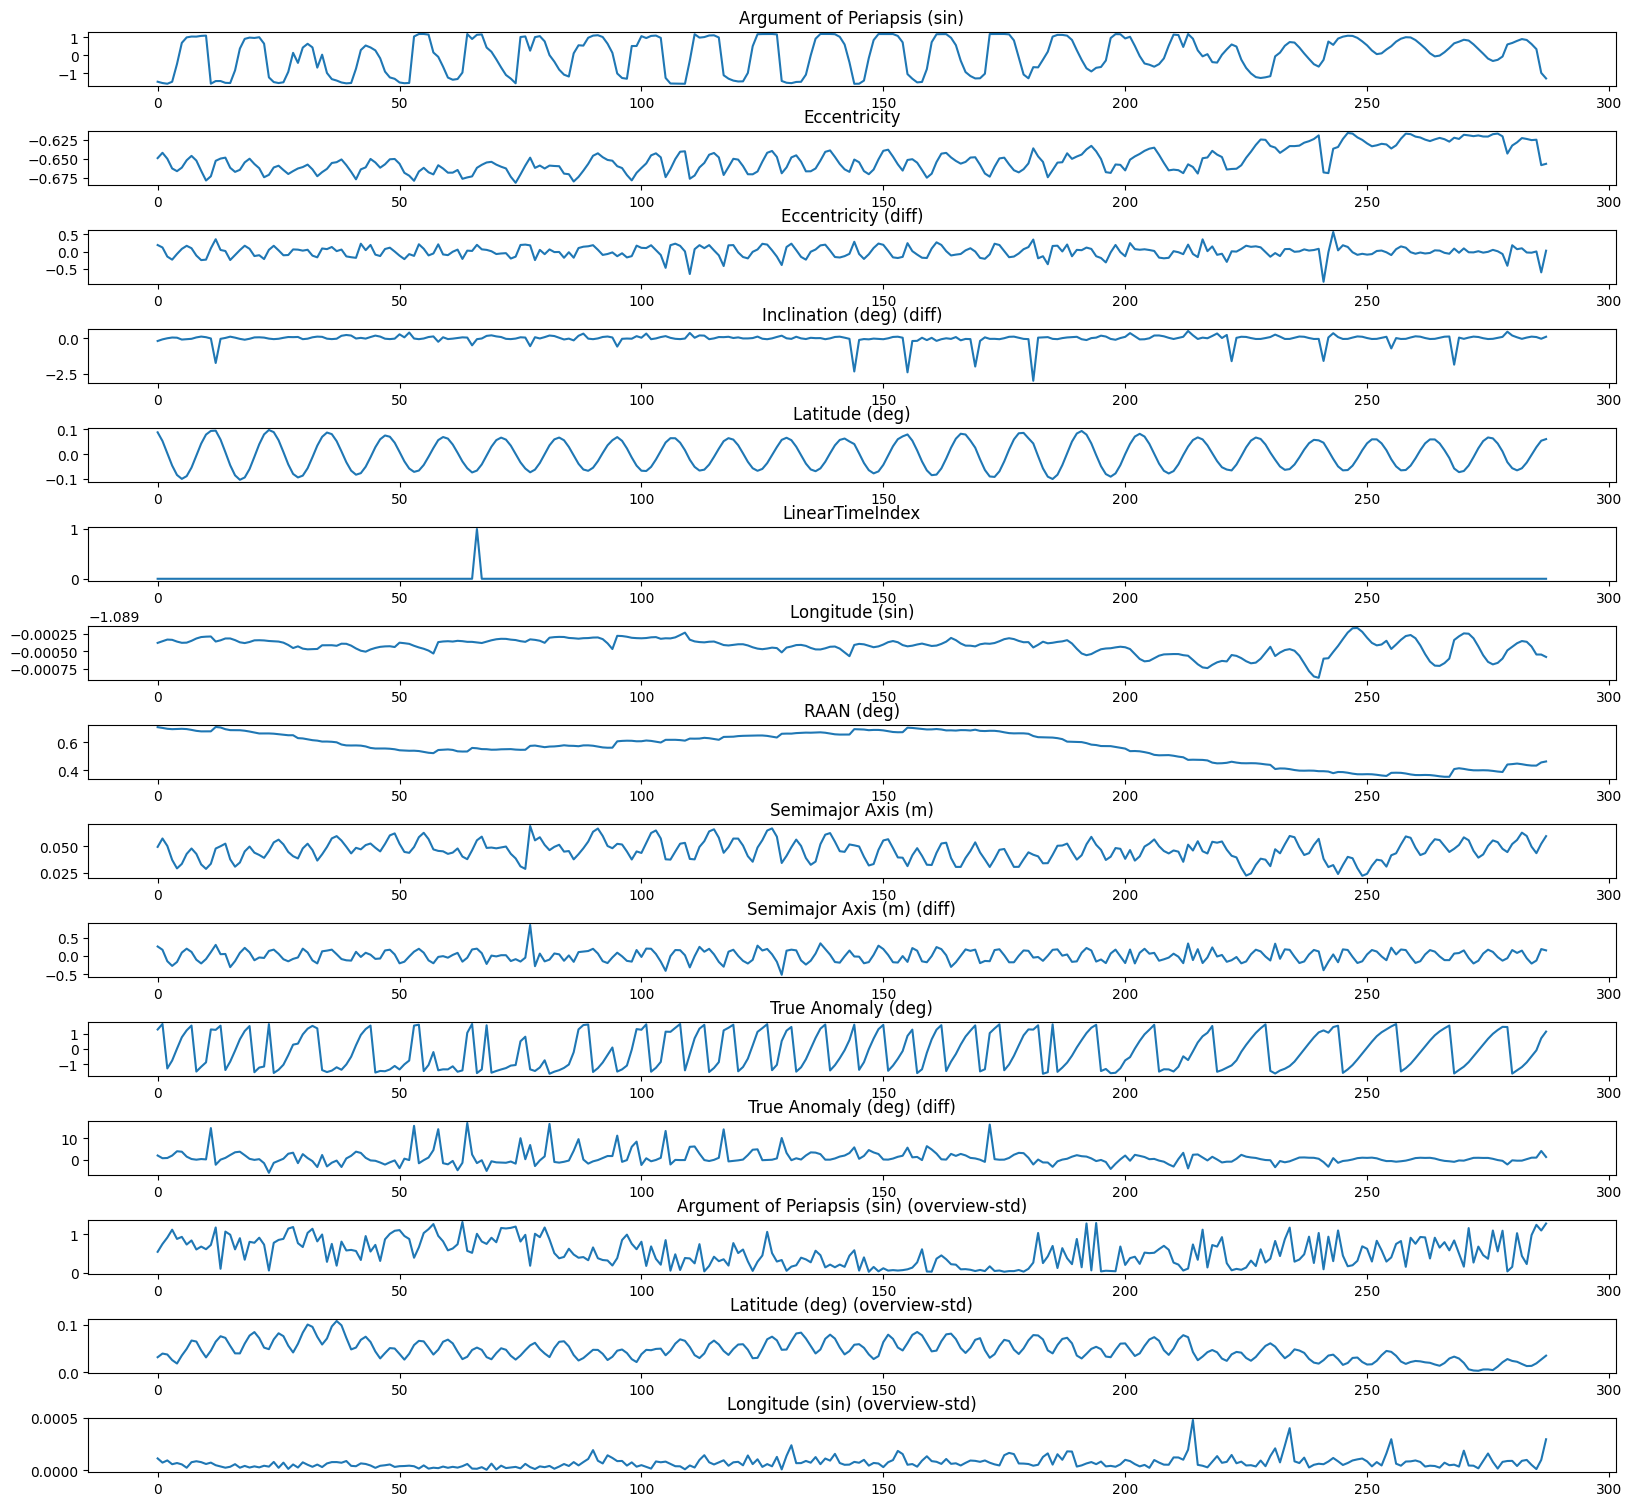

In [11]:
ds_gen.plot_dataset_item(objectid=222, timeindex=500)

In [33]:
# Get the datasets
datasets = ds_gen.get_datasets(batch_size=128, 
                                label_features=['EW_Type', 'NS_Type'],
                                with_identifier=False, 
                                only_nodes=False, 
                                overview_as_second_input=False,
                                shuffle=True, 
                                stride=1,
                                keep_label_stride=1000,
                                stride_offset=250,
                                verbose=1)
print(datasets['val'].element_spec)

  0%|          | 0/1511 [00:00<?, ?it/s]

100%|██████████| 499/499 [00:04<00:00, 105.01it/s]


DS-Cardinalities: ['train: 8292', 'val: 2068', 'test: 1953']
({'local_in': TensorSpec(shape=(None, 288, 15), dtype=tf.float32, name=None)}, {'EW_Type': TensorSpec(shape=(None,), dtype=tf.int32, name=None), 'NS_Type': TensorSpec(shape=(None,), dtype=tf.int32, name=None)})


#### Create & Train Model
It is also possible to load a prepared model instead (see next section)

In [34]:
model = prediction_models.Dense_NN(datasets['val'],
                                    conv1d_layers=[],
                                    dense_layers=[64,32],
                                    lstm_layers=[[64,True,6,1]],
                                    cnn_lstm_order='lstm_cnn',
                                    split_cnn=True,
                                    split_dense=False,
                                    split_lstm=True,
                                    l2_reg=0.0001,
                                    input_dropout=0.0,
                                    mixed_dropout_dense=0.0,
                                    mixed_dropout_cnn=0.0,
                                    mixed_dropout_lstm=0.0,
                                    mixed_batchnorm_cnn=False,
                                    mixed_batchnorm_dense=False,
                                    mixed_batchnorm_lstm=False,
                                    mixed_batchnorm_before_relu=False,
                                    optimizer='adam',
                                    lr_scheduler=[0.0035, 700, 0.9],
                                    output_type='classification',
                                    seed=42)

model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 local_in (InputLayer)       [(None, 288, 15)]            0         []                            
                                                                                                  
 lstm_0_L_local (LSTM)       (None, 288, 64)              20480     ['local_in[0][0]']            
                                                                                                  
 lstm_0_R_local (LSTM)       (None, 288, 64)              20480     ['local_in[0][0]']            
                                                                                                  
 lstm_MP_0_L_local (MaxPool  (None, 48, 64)               0         ['lstm_0_L_local[0][0]']      
 ing1D)                                                                                     

In [35]:
#tf.keras.utils.plot_model(model.model)

Starting training. Optimizing "val_EW_Type_accuracy"
Epoch 1/500


65/65 - 7s - loss: 1.2545 - EW_Type_loss: 0.6714 - NS_Type_loss: 0.5469 - EW_Type_accuracy: 0.7241 - NS_Type_accuracy: 0.7849 - val_loss: 0.8319 - val_EW_Type_loss: 0.4986 - val_NS_Type_loss: 0.2896 - val_EW_Type_accuracy: 0.7916 - val_NS_Type_accuracy: 0.9038 - 7s/epoch - 109ms/step
Epoch 2/500
65/65 - 3s - loss: 0.6623 - EW_Type_loss: 0.3955 - NS_Type_loss: 0.2175 - EW_Type_accuracy: 0.8459 - NS_Type_accuracy: 0.9234 - val_loss: 0.6276 - val_EW_Type_loss: 0.3673 - val_NS_Type_loss: 0.2058 - val_EW_Type_accuracy: 0.8559 - val_NS_Type_accuracy: 0.9265 - 3s/epoch - 39ms/step
Epoch 3/500
65/65 - 2s - loss: 0.4733 - EW_Type_loss: 0.2740 - NS_Type_loss: 0.1395 - EW_Type_accuracy: 0.9024 - NS_Type_accuracy: 0.9515 - val_loss: 0.5273 - val_EW_Type_loss: 0.3080 - val_NS_Type_loss: 0.1541 - val_EW_Type_accuracy: 0.8902 - val_NS_Type_accuracy: 0.9512 - 2s/epoch - 38ms/step
Epoch 4/500
65/65 - 3s - loss: 0.3795 - EW_Type_loss: 0.2156 - NS_Type_loss: 0.0940 - EW_Type_accuracy: 0.9241 - NS_Type_ac

/home/david/Code/splid-challenge/base/prediction_models.py:74: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


17/17 [==============================] - 0s 19ms/step - loss: 0.3283 - EW_Type_loss: 0.1846 - NS_Type_loss: 0.1056 - EW_Type_accuracy: 0.9637 - NS_Type_accuracy: 0.9802


[0.3282795250415802,
 0.18459837138652802,
 0.10560119152069092,
 0.9637330770492554,
 0.9801740646362305]

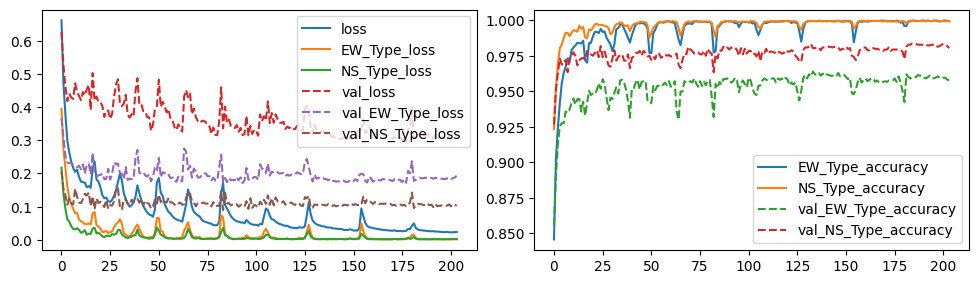

In [36]:
# fix to allow class weights
# train_combined= train_combined.map(lambda x,y:(x,y[f'EW_Type']))
# val_combined = val_combined.map(lambda x,y:(x,y[f'EW_Type'])) 

hist = model.fit(datasets['train'],
                val_ds=datasets['val'],
                epochs=500,
                verbose=2,
                plot_hist=True,
                save_best_only=True,
                early_stopping=70,
                target_metric='val_EW_Type_accuracy',
                #class_weight={0: w_0, 1: w_1, 2: w_2, 3: w_3},
                callbacks=[])
model.evaluate(datasets['val'])
#model.save('models/ew_ns_classifier_new.hdf5')

#### Evaluation

In [25]:
# Optional: load existing model
#model = tf.keras.models.load_model("models/classifier_model_fixedDiffTransform.hdf5", compile=True)
scaler2 = pickle.load(open('models/scaler_model_fixedDiffTransform.pkl', 'rb')) 

3/3 [==============================] - 1s 33ms/step


/home/david/Code/splid-challenge/base/classifier.py:53: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


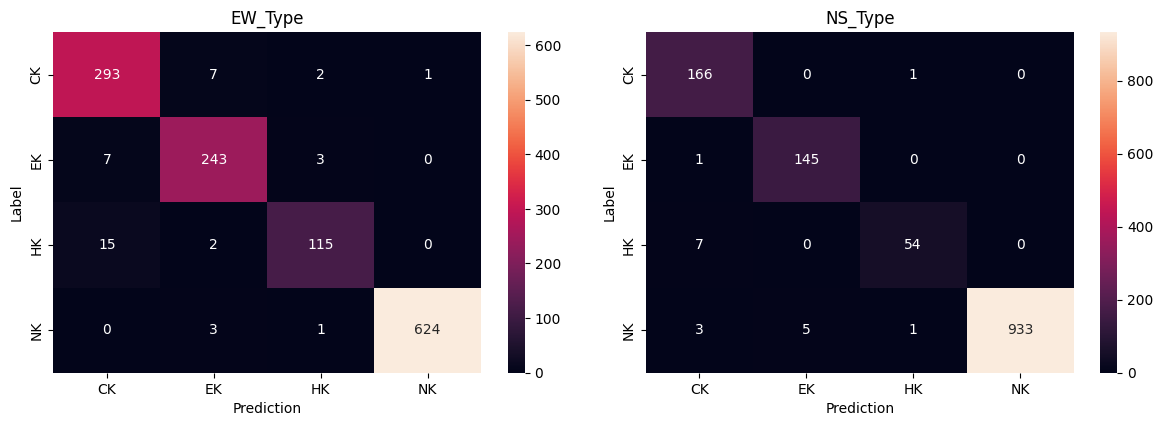

In [37]:
# Collect type predictions on every node location
pred_df = classifier.create_prediction_df(ds_gen=ds_gen,
                                model=model,
                                ds_type='val',
                                model_outputs=['EW_Type', 'NS_Type'],#, 'NS_Type'],
                                object_limit=None,
                                only_nodes=True,
                                confusion_matrix=True,
                                prediction_batch_size=2048,
                                verbose=1)

In [38]:
ground_truth_df = pd.read_csv(train_val_labels_dir)#.sort_values(['ObjectID', 'TimeIndex']).reset_index(drop=True)
ground_truth_df=ground_truth_df.loc[(ground_truth_df['Node'] != 'ES')].copy()

# In the current implementation, we could assume ID nodes to be known as they are detected by a dedicated ID-localizer
ground_truth_df.loc[ground_truth_df['Node'] != 'ID', 'Type'] = 'UNKNOWN'
ground_truth_df.loc[ground_truth_df['Node'] != 'ID', 'Node'] = 'UNKNOWN'
#ground_truth_df['Node'] = 'UNKNOWN'
#ground_truth_df['Type'] = 'UNKNOWN'

# Perform the postprocessing, ie assigning node-classes based on the predicted types
typed_df = classifier.fill_unknown_types_based_on_preds(pred_df, ground_truth_df, dirs=['EW', 'NS'])
classified_df = classifier.fill_unknwon_nodes_based_on_type(typed_df, dirs=['EW', 'NS'])

# Perform the evaluation
ground_truth_eval_df = pd.read_csv(train_val_labels_dir) # re-load unmodified ground truth
evaluator = evaluation.NodeDetectionEvaluator(ground_truth=ground_truth_eval_df, participant=classified_df, ignore_nodes=False)
precision, recall, f2, rmse, total_tp, total_fp, total_fn, total_df = evaluator.score()
print(f'Precision: {precision:.3f}')
print(f'TP: {total_tp} FP: {total_fp}')

Precision: 0.986
TP: 1793 FP: 26


In [12]:
# Save model and scaler
pickle.dump(ds_gen.scaler, open('models/new_classifier_scaler.pkl', 'wb'))
model.save('models/new_classifier_model.hdf5')


/home/david/miniconda3/envs/splid-gpu/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
